## 🧾 Tahap 1A — Membaca dan Menampilkan Data Saham ANTM Saja

Langkah ini memuat data mentah dari saham ANTM saja, yang terdiri dari kolom:
- Tanggal (`Date`)
- Harga: `Open`, `High`, `Low`, `Close`
- Volume: `Volume`
- Persentase perubahan: `Change %`

Data akan digunakan untuk baseline model (tanpa faktor eksternal).

In [1]:
import pandas as pd

# Baca file ANTM
antm = pd.read_csv('../data/raw/antm_10y.csv')

# Tampilkan 5 baris awal
print("📊 ANTM Saham Mentah:")
display(antm.head())

📊 ANTM Saham Mentah:


,Date,Price,Open,High,Low,Vol.,Change %
0,06/20/2025,"3,200","3,330","3,340","3,160",223.74M,-3.90%
1,06/19/2025,"3,330","3,560","3,580","3,300",230.24M,-6.20%
2,06/18/2025,"3,550","3,500","3,590","3,470",242.73M,2.31%
3,06/17/2025,"3,470","3,280","3,490","3,240",289.46M,5.79%
4,06/16/2025,"3,280","3,330","3,370","3,230",177.10M,-0.61%


## 🧹 Tahap 1B — Pembersihan dan Standarisasi Kolom ANTM

Langkah ini membersihkan format angka dan tanggal:
- Mengubah Volume dari string ('2.3M') ke angka (`2300000`)
- Menghapus simbol `%` pada kolom `Change %`
- Mengonversi kolom `Date` ke format `datetime`

In [3]:
import numpy as np

# Salin dataframe
df = antm.copy()

# Rename kolom jika ada 'Price'
if 'Price' in df.columns:
    df.rename(columns={'Price': 'Close'}, inplace=True)

# Rename kolom 'Vol.' menjadi 'Volume'
if 'Vol.' in df.columns:
    df.rename(columns={'Vol.': 'Volume'}, inplace=True)

# Rename kolom agar konsisten
df.columns = df.columns.str.strip().str.replace('%', '').str.replace('Change ', 'Change')

# Ubah kolom Date ke datetime
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y', errors='coerce')

# Bersihkan Volume (ubah K, M, B → angka)
def parse_volume(val):
    if isinstance(val, str):
        val = val.replace(',', '')
        if 'K' in val:
            return float(val.replace('K', '')) * 1e3
        elif 'M' in val:
            return float(val.replace('M', '')) * 1e6
        elif 'B' in val:
            return float(val.replace('B', '')) * 1e9
        else:
            return float(val)
    return np.nan

df['Volume'] = df['Volume'].apply(parse_volume)

# Bersihkan Change: hilangkan simbol + dan ubah ke float
df['Change'] = df['Change'].str.replace('%', '').str.replace('+', '').str.replace(',', '').astype(float)

# Sortir tanggal dan filter range 2020–2025
df = df.sort_values('Date')
df = df[(df['Date'] >= '2020-01-01') & (df['Date'] <= '2025-06-23')].reset_index(drop=True)

# Simpan hanya kolom yang dibutuhkan
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Change']]
display(df.head())


,Date,Open,High,Low,Close,Volume,Change
0,2020-01-02,845,850,825,840,26830000.0,0.00
1,2020-01-03,845,850,840,850,52110000.0,1.19
2,2020-01-06,860,890,855,885,153320000.0,4.12
3,2020-01-07,885,895,865,875,93750000.0,-1.13
4,2020-01-08,895,920,890,905,217120000.0,3.43


## ⚖️ Tahap 1C — Normalisasi Fitur Numerik Saham ANTM

Semua fitur numerik (selain tanggal) akan dinormalisasi menggunakan Min-Max Scaling.
Hasil normalisasi disimpan dalam `scaled_df_antm_only`.

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Ambil fitur numerik saja
features = df.drop(columns=['Date'])

# Bersihkan angka koma jika ada (untuk berjaga-jaga)
features_cleaned = features.applymap(lambda x: str(x).replace(',', '')).astype(float)

# Normalisasi
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(features_cleaned)

# Simpan ke dataframe baru dengan kolom asli
scaled_df_antm_only = pd.DataFrame(scaled_values, columns=features.columns)

# Tambahkan kembali kolom tanggal
scaled_df_antm_only.insert(0, 'Date', df['Date'])

# Lihat hasil awal
display(scaled_df_antm_only.head())

C:\Users\User\AppData\Local\Temp\ipykernel_31540\3099758574.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features_cleaned = features.applymap(lambda x: str(x).replace(',', '')).astype(float)


,Date,Open,High,Low,Close,Volume,Change
0,2020-01-02,0.153300,0.147451,0.155492,0.153654,0.008184,0.366488
1,2020-01-03,0.153300,0.147451,0.160281,0.156777,0.019775,0.396838
2,2020-01-06,0.157927,0.159587,0.165070,0.167708,0.066180,0.471563
3,2020-01-07,0.165638,0.161104,0.168263,0.164585,0.038867,0.337669
4,2020-01-08,0.168723,0.168689,0.176245,0.173954,0.095432,0.453966


## 📊 Tahap 1D — Visualisasi Distribusi Fitur ANTM (Setelah Normalisasi)

Grafik histogram berikut menampilkan distribusi nilai setiap fitur setelah dinormalisasi menggunakan Min-Max Scaling.
Diharapkan seluruh nilai berada di rentang [0, 1].

<Figure size 1200x600 with 0 Axes>

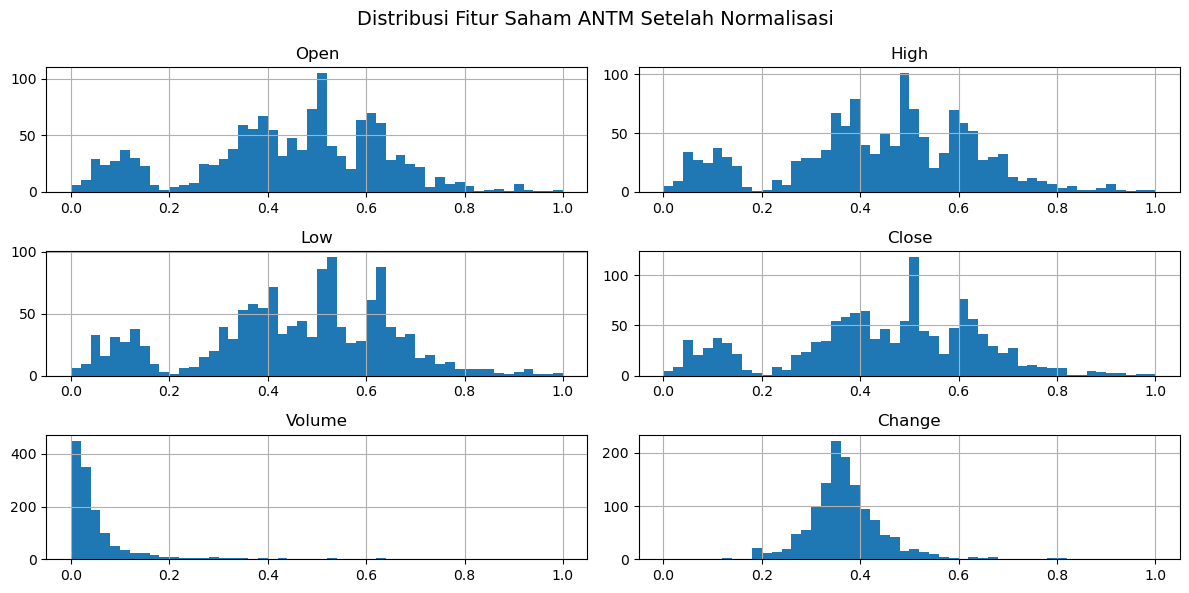

In [5]:
import matplotlib.pyplot as plt

# Plot histogram untuk semua fitur (kecuali tanggal)
plt.figure(figsize=(12, 6))
scaled_df_antm_only.drop(columns=['Date']).hist(bins=50, figsize=(12, 6))
plt.suptitle("Distribusi Fitur Saham ANTM Setelah Normalisasi", fontsize=14)
plt.tight_layout()
plt.show()

## 🪟 Tahap 2A — Sliding Window untuk Dataset ANTM

Langkah ini mengubah data time series menjadi format supervised learning.
Setiap sampel input akan terdiri dari `window_size` hari ke belakang, dan target (`y`) adalah harga penutupan (`Close`) hari berikutnya.

In [6]:
import numpy as np

# Konfigurasi
window_size = 7

# Buat array input-output
X_antm = []
y_antm = []

# Ambil nilai hanya fitur numerik (tanpa tanggal)
features = scaled_df_antm_only.drop(columns=['Date']).values
target_index = list(scaled_df_antm_only.columns).index('Close') - 1  # indeks kolom Close (tanpa Date)

# Sliding window loop
for i in range(window_size, len(features)):
    X_antm.append(features[i - window_size:i])
    y_antm.append(features[i, target_index])

# Konversi ke array numpy
X_antm = np.array(X_antm)
y_antm = np.array(y_antm).reshape(-1, 1)

# Untuk model BPNN (tanpa dimensi time)
X_flat_antm = X_antm.reshape((X_antm.shape[0], -1))

# Validasi bentuk
print(f"✅ X shape (CLSTM): {X_antm.shape}")
print(f"✅ X_flat shape (BPNN): {X_flat_antm.shape}")
print(f"✅ y shape: {y_antm.shape}")

✅ X shape (CLSTM): (1308, 7, 6)
✅ X_flat shape (BPNN): (1308, 42)
✅ y shape: (1308, 1)


## ✂️ Tahap 2B — Pembagian Data Train/Test untuk Data Saham ANTM

Dataset hasil windowing akan dibagi menjadi 80% untuk pelatihan dan 20% untuk pengujian. Pembagian dilakukan tanpa acak (no shuffling) untuk mempertahankan urutan time series.

In [7]:
# Hitung index split
split_index = int(0.8 * len(X_antm))

# Bagi data untuk CLSTM
X_train_antm, X_test_antm = X_antm[:split_index], X_antm[split_index:]
y_train_antm, y_test_antm = y_antm[:split_index], y_antm[split_index:]

# Bagi data untuk BPNN
X_flat_train_antm, X_flat_test_antm = X_flat_antm[:split_index], X_flat_antm[split_index:]

# Konfirmasi bentuk
print(f"🔹 CLSTM - X_train: {X_train_antm.shape}, y_train: {y_train_antm.shape}")
print(f"🔹 CLSTM - X_test: {X_test_antm.shape}, y_test: {y_test_antm.shape}")
print(f"🔸 BPNN  - X_flat_train: {X_flat_train_antm.shape}, X_flat_test: {X_flat_test_antm.shape}")

🔹 CLSTM - X_train: (1046, 7, 6), y_train: (1046, 1)
🔹 CLSTM - X_test: (262, 7, 6), y_test: (262, 1)
🔸 BPNN  - X_flat_train: (1046, 42), X_flat_test: (262, 42)


## 🧠 Pelatihan Model CLSTM untuk Data ANTM (Tanpa Eksternal)

Model CLSTM dikombinasikan dari Conv1D dan LSTM untuk menangkap pola spasial dan temporal dari data time series. Model ini akan dilatih menggunakan data saham ANTM tanpa faktor eksternal.


In [10]:
from keras.models import Sequential
from keras.layers import Input, Conv1D, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

# Definisikan model CLSTM dengan Input() di awal
model_clstm_antm = Sequential([
    Input(shape=(X_train_antm.shape[1], X_train_antm.shape[2])),  # <- Input layer eksplisit
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

# Kompilasi model
model_clstm_antm.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Latih model
history_clstm_antm = model_clstm_antm.fit(
    X_train_antm, y_train_antm,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_antm, y_test_antm),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1000 - mae: 0.2452 - val_loss: 0.0028 - val_mae: 0.0399
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - mae: 0.0533 - val_loss: 0.0028 - val_mae: 0.0346
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mae: 0.0420 - val_loss: 0.0016 - val_mae: 0.0264
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026 - mae: 0.0376 - val_loss: 0.0020 - val_mae: 0.0290
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - mae: 0.0360 - val_loss: 0.0014 - val_mae: 0.0250
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - mae: 0.0335 - val_loss: 0.0016 - val_mae: 0.0256
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 - mae: 0.0348 - val_loss: 0.0019 - val_mae: 0.0282
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - mae: 0.0329 - val_loss: 0.0017 - val_mae: 0.0263
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - mae:

## 📏 Evaluasi Metrik CLSTM (ANTM Only)
Evaluasi dilakukan terhadap data uji dengan tiga metrik:
- MAE: Rata-rata error absolut
- MSE: Rata-rata error kuadrat
- RMSE: Akar dari MSE (mewakili satuan asli)

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Prediksi terhadap data uji
y_pred_clstm_antm = model_clstm_antm.predict(X_test_antm)

# Hitung metrik evaluasi
mae_clstm_antm = mean_absolute_error(y_test_antm, y_pred_clstm_antm)
mse_clstm_antm = mean_squared_error(y_test_antm, y_pred_clstm_antm)
rmse_clstm_antm = np.sqrt(mse_clstm_antm)

# Tampilkan hasil
print(f"📊 MAE  = {mae_clstm_antm:.6f}")
print(f"📊 MSE  = {mse_clstm_antm:.6f}")
print(f"📊 RMSE = {rmse_clstm_antm:.6f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
📊 MAE  = 0.018674
📊 MSE  = 0.000822
📊 RMSE = 0.028665


In [17]:
# Simpan model CLSTM untuk data ANTM saja (tanpa eksternal)
model_clstm_antm.save("../models/clstm_antm_only.keras")
print("✅ Model CLSTM (ANTM Only) berhasil disimpan di folder models/")

✅ Model CLSTM (ANTM Only) berhasil disimpan di folder models/


## 📉 Visualisasi Prediksi vs Aktual (CLSTM - ANTM Only)

Grafik ini memperlihatkan kemampuan model dalam mengikuti pola harga saham ANTM berdasarkan data training tanpa faktor eksternal.

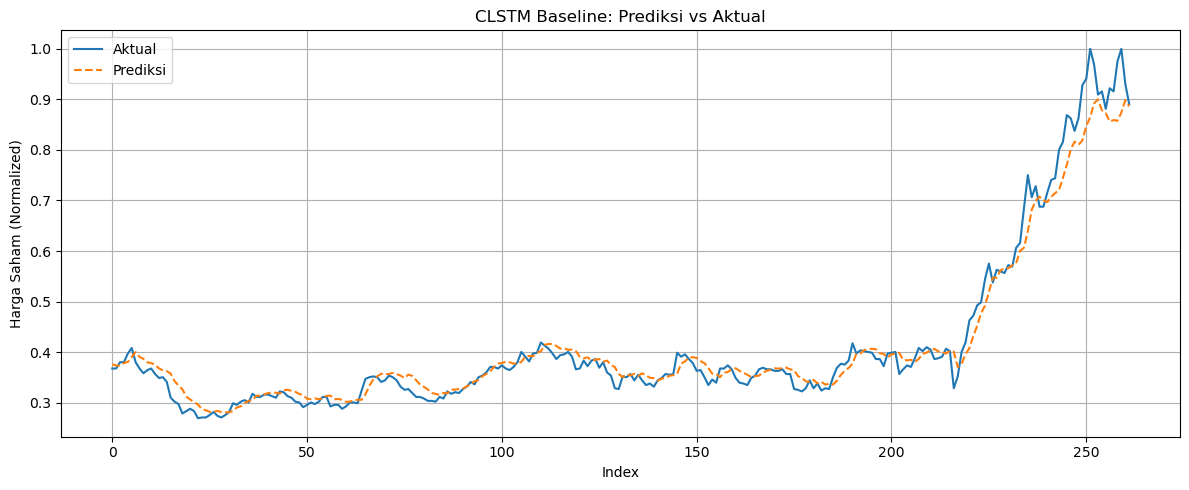

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test_antm, label='Aktual')
plt.plot(y_pred_clstm_antm, label='Prediksi', linestyle='--')
plt.title('CLSTM Baseline: Prediksi vs Aktual')
plt.xlabel('Index')
plt.ylabel('Harga Saham (Normalized)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 📈 Grafik Loss Training dan Validasi
Kurva ini menunjukkan perubahan nilai loss MSE sepanjang pelatihan.

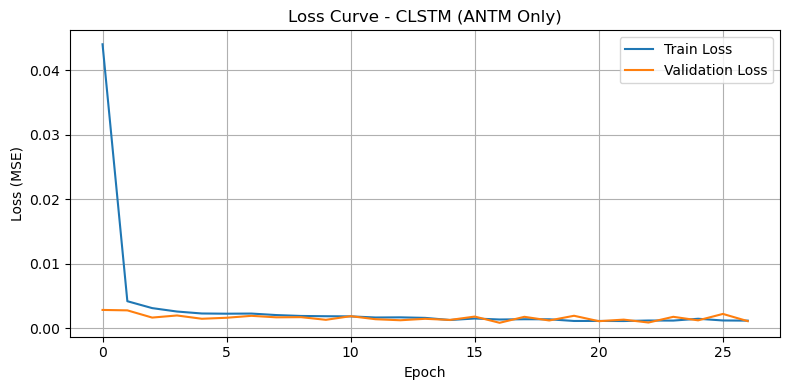

In [13]:
plt.figure(figsize=(8, 4))
plt.plot(history_clstm_antm.history['loss'], label='Train Loss')
plt.plot(history_clstm_antm.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve - CLSTM (ANTM Only)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 🧠 Pelatihan Model BPNN (Baseline - ANTM Only)

Model BPNN (Backpropagation Neural Network) digunakan sebagai baseline tanpa mempertimbangkan faktor eksternal.
Arsitektur terdiri dari 2 hidden layer dengan fungsi aktivasi ReLU, dropout sebagai regularisasi, dan output linear.

Data yang digunakan merupakan hasil flatten dari sliding window pada fitur-fitur saham ANTM saja.

Model dilatih menggunakan fungsi loss **Mean Squared Error (MSE)** dan dioptimasi dengan algoritma **Adam**.

In [14]:
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.callbacks import EarlyStopping

# Arsitektur model BPNN
model_bpnn_antm = Sequential([
    Input(shape=(X_flat_train_antm.shape[1],)),  # Input layer eksplisit
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

# Kompilasi model
model_bpnn_antm.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Inisialisasi early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Latih model
history_bpnn_antm = model_bpnn_antm.fit(
    X_flat_train_antm, y_train_antm,
    epochs=50,
    batch_size=32,
    validation_data=(X_flat_test_antm, y_test_antm),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0247 - mae: 0.1193 - val_loss: 0.0024 - val_mae: 0.0363
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051 - mae: 0.0542 - val_loss: 0.0062 - val_mae: 0.0592
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - mae: 0.0454 - val_loss: 0.0056 - val_mae: 0.0493
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029 - mae: 0.0403 - val_loss: 0.0056 - val_mae: 0.0532
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - mae: 0.0387 - val_loss: 0.0084 - val_mae: 0.0699
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - mae: 0.0392 - val_loss: 0.0068 - val_mae: 0.0644
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026 - mae: 0.0379 - val_loss: 0.0046 - val_mae: 0.0443
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - mae: 0.0349 - val_loss: 0.0061 - val_mae: 0.0582
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - mae: 

## ✅ Evaluasi dan Visualisasi Model BPNN (Baseline - ANTM Only)

Model BPNN yang telah dilatih dievaluasi terhadap data test menggunakan metrik:
- **Mean Absolute Error (MAE)**
- **Mean Squared Error (MSE)**
- **Root Mean Squared Error (RMSE)**

Grafik prediksi vs aktual membantu mengamati seberapa baik model mengikuti pola harga saham.

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
🔎 MAE  = 0.036284
🔎 MSE  = 0.002353
🔎 RMSE = 0.048507


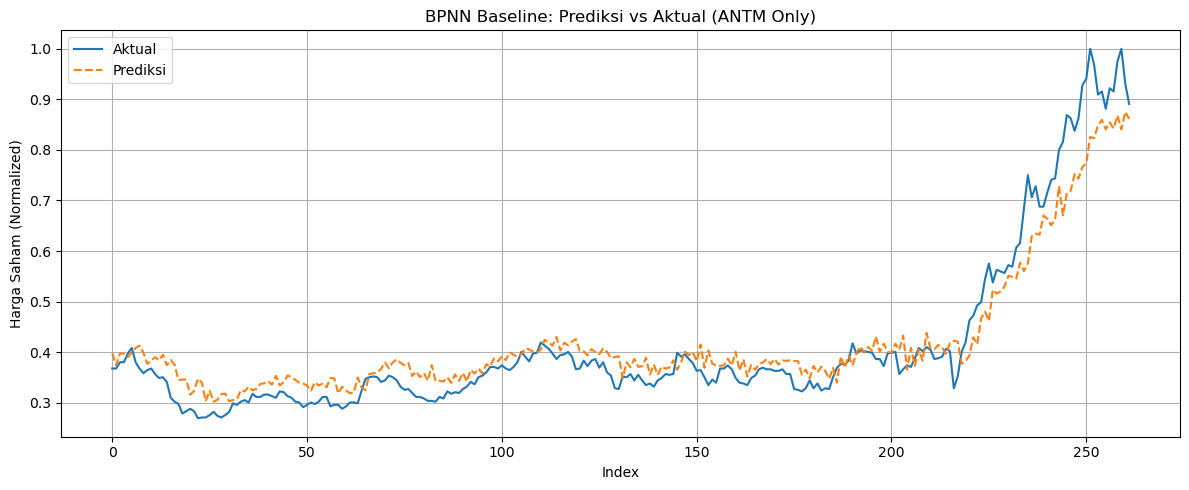

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Prediksi
y_pred_bpnn_antm = model_bpnn_antm.predict(X_flat_test_antm)

# Evaluasi
mae = mean_absolute_error(y_test_antm, y_pred_bpnn_antm)
mse = mean_squared_error(y_test_antm, y_pred_bpnn_antm)
rmse = np.sqrt(mse)

print(f"🔎 MAE  = {mae:.6f}")
print(f"🔎 MSE  = {mse:.6f}")
print(f"🔎 RMSE = {rmse:.6f}")

# Visualisasi hasil prediksi
plt.figure(figsize=(12, 5))
plt.plot(y_test_antm, label='Aktual')
plt.plot(y_pred_bpnn_antm, label='Prediksi', linestyle='--')
plt.title('BPNN Baseline: Prediksi vs Aktual (ANTM Only)')
plt.xlabel('Index')
plt.ylabel('Harga Saham (Normalized)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# Simpan model BPNN (ANTM Only) dalam format .keras
model_bpnn_antm.save("../models/bpnn_antm_only.keras")
print("✅ Model BPNN (ANTM Only) berhasil disimpan di folder models/")

✅ Model BPNN (ANTM Only) berhasil disimpan di folder models/


## 📉 Grafik Loss Training dan Validasi - BPNN (ANTM Only)

Kurva berikut menunjukkan perubahan nilai loss (MSE) selama pelatihan untuk data saham ANTM.
Grafik ini memberikan indikasi kestabilan model dan potensi overfitting.

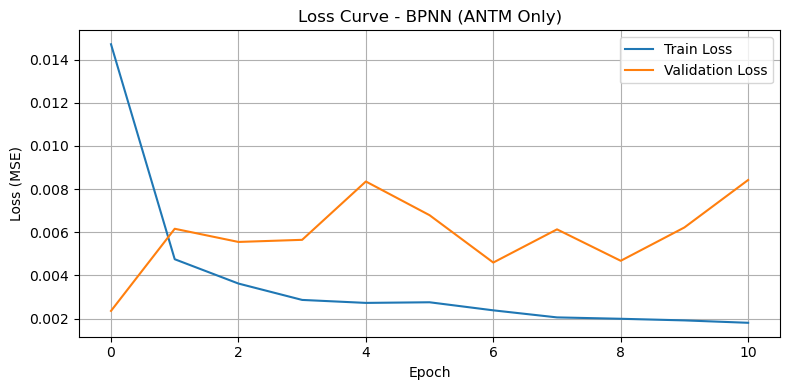

In [16]:
plt.figure(figsize=(8, 4))
plt.plot(history_bpnn_antm.history['loss'], label='Train Loss')
plt.plot(history_bpnn_antm.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve - BPNN (ANTM Only)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()